# Supply Chain Optimization Analysis

## Project Aim

This project analyzes delivery delays and inventory gaps within a supply chain. The aim is to propose actionable logistics improvements to reduce bottlenecks.

## Step 1: Data Acquisition

This phase focuses on obtaining the raw supply chain data necessary for the optimization project.

In [1]:
import pandas as pd

# Define the file path for the dataset.
# The dataset is expected to be uploaded to the Colab environment.
file_path = '/content/supply_chain_resilience_dataset.csv' # Assuming this file name

print("Starting Step 1 Data Acquisition")
print("1.1 Loading the dataset with correct delimiter...")

# Load the raw supply chain data into a DataFrame.
# A try except block is used for robust file handling.
try:
    df_supply = pd.read_csv(file_path) # Assuming comma-separated values
    print(f"Dataset loaded successfully from: {file_path}")
    print("First 5 rows of CORRECTLY LOADED data:")
    print(df_supply.head())
    print("Information about CORRECTLY LOADED data:")
    print(df_supply.info())
except FileNotFoundError:
    print(f"ERROR File not found at {file_path}. Ensure the CSV is uploaded to Colab.")
    exit()
except Exception as e:
    print(f"ERROR An unexpected error occurred during file loading. Error: {e}")
    exit()

print("Step 1 Data Acquisition Complete")
print("The df_supply DataFrame is now available for initial inspection and cleaning.")

Starting Step 1 Data Acquisition
1.1 Loading the dataset with correct delimiter...
Dataset loaded successfully from: /content/supply_chain_resilience_dataset.csv
First 5 rows of CORRECTLY LOADED data:
  Order_ID Buyer_ID Supplier_ID Product_Category  Quantity_Ordered  \
0    O1000      B33         S23         Textiles               469   
1    O1001       B1         S20        Machinery               365   
2    O1002       B2         S10             Food               333   
3    O1003       B6         S10        Machinery               142   
4    O1004       B5          S4        Machinery               897   

   Order_Date Dispatch_Date Delivery_Date Shipping_Mode  Order_Value_USD  ...  \
0  2023-10-24    2023-10-27    2023-10-28          Rail         36273.99  ...   
1  2023-07-07    2023-07-08    2023-07-09          Road         34780.36  ...   
2  2023-12-28    2023-12-29    2024-01-07          Rail          7154.54  ...   
3  2023-01-14    2023-01-17    2023-01-20          Rai

## Step 2: Data Cleaning and Preprocessing

This phase refines the raw supply chain data by correcting data types and addressing any inconsistencies, preparing it for analysis.

In [2]:
import pandas as pd
import numpy as np

# A note on prerequisites: The df_supply DataFrame must be available from Step 1 (Data Acquisition).

print("Starting Step 2 Data Cleaning and Preprocessing")

# 1. Convert Date columns to datetime objects.
# These columns are essential for time series analysis and delay calculations.
print("1. Converting date columns to datetime format.")
date_columns = ['Order_Date', 'Dispatch_Date', 'Delivery_Date']
for col in date_columns:
    df_supply[col] = pd.to_datetime(df_supply[col])
print("Date columns converted.")

# 2. Inspecting and handling 'None' string in Disruption_Type.
# The presence of 'None' as a string indicates no disruption, but should be handled consistently.
# Converting 'None' to NaN then filling with a specific string 'No_Disruption' or simply replacing.
# For simplicity, replacing 'None' string directly with 'No_Disruption'.
print("2. Handling 'None' string in Disruption Type column.")
if 'Disruption_Type' in df_supply.columns:
    df_supply['Disruption_Type'] = df_supply['Disruption_Type'].replace('None', 'No_Disruption')
    print("Disruption Type 'None' values replaced with 'No_Disruption'.")

# 3. Inspecting Disruption_Severity for consistency.
# This column may also contain 'None' or require specific handling for categorical analysis.
print("3. Inspecting and handling Disruption Severity column.")
if 'Disruption_Severity' in df_supply.columns:
    df_supply['Disruption_Severity'] = df_supply['Disruption_Severity'].replace('None', 'No_Disruption')
    print("Disruption Severity 'None' values replaced with 'No_Disruption'.")

# 4. Checking for duplicate Order_ID.
# Duplicate order IDs might indicate data entry errors or specific order handling.
print("4. Checking for duplicate Order ID entries.")
duplicate_orders = df_supply['Order_ID'].duplicated().sum()
if duplicate_orders > 0:
    print(f"Found {duplicate_orders} duplicate Order ID entries. Removing duplicates.")
    df_supply.drop_duplicates(subset=['Order_ID'], inplace=True)
else:
    print("No duplicate Order ID entries found.")

print("Step 2 Data Cleaning and Preprocessing Complete")
print("The df_supply DataFrame is now cleaned and preprocessed for further transformation.")

Starting Step 2 Data Cleaning and Preprocessing
1. Converting date columns to datetime format.
Date columns converted.
2. Handling 'None' string in Disruption Type column.
Disruption Type 'None' values replaced with 'No_Disruption'.
3. Inspecting and handling Disruption Severity column.
Disruption Severity 'None' values replaced with 'No_Disruption'.
4. Checking for duplicate Order ID entries.
No duplicate Order ID entries found.
Step 2 Data Cleaning and Preprocessing Complete
The df_supply DataFrame is now cleaned and preprocessed for further transformation.


## Step 3: Transform Data

This step involves creating new, useful features from existing data and preparing the dataset for specific analyses like time-series forecasting and clustering.

In [3]:
import pandas as pd
import numpy as np

print("Starting Step 3 Transform Data")

# 1. Create new time-related features.
# These features extract more granular time information from date columns, useful for patterns.
print("1. Creating new time-related features.")

df_supply['Order_DayOfWeek'] = df_supply['Order_Date'].dt.dayofweek # Day of week order was placed (0=Mon, 6=Sun)
df_supply['Order_Month'] = df_supply['Order_Date'].dt.month         # Month order was placed
df_supply['Order_Year'] = df_supply['Order_Date'].dt.year           # Year order was placed
df_supply['Delivery_DayOfWeek'] = df_supply['Delivery_Date'].dt.dayofweek # Day of week delivery occurred
df_supply['Delivery_Month'] = df_supply['Delivery_Date'].dt.month     # Month delivery occurred
df_supply['Delivery_Year'] = df_supply['Delivery_Date'].dt.year       # Year delivery occurred

# 2. Calculate Lead Time.
# Lead time is the duration from order placement to dispatch.
print("2. Calculating Lead Time in days.")
df_supply['Lead_Time_Days'] = (df_supply['Dispatch_Date'] - df_supply['Order_Date']).dt.days

# 3. Calculate Actual Transit Time.
# Transit time is the duration from dispatch to delivery.
print("3. Calculating Actual Transit Time in days.")
df_supply['Actual_Transit_Time_Days'] = (df_supply['Delivery_Date'] - df_supply['Dispatch_Date']).dt.days

# 4. Create a categorical Delivery Performance flag.
# This feature indicates if a delivery was delayed (1) or on time (0).
print("4. Creating a Delivery Performance flag (Delayed or On Time).")
df_supply['Delivery_Performance_Delayed'] = (df_supply['Delay_Days'] > 0).astype(int)

# 5. Handle 'No_Disruption' encoding for Disruption_Severity.
# Convert this categorical column into a numerical representation for modeling.
# It is assumed 'None' strings were replaced by 'No_Disruption' in Step 2.
print("5. Encoding Disruption Severity for numerical analysis.")
# Ordinal encoding is suitable if there's a clear order (Low < Medium < High).
severity_mapping = {'No_Disruption': 0, 'Low': 1, 'Medium': 2, 'High': 3}
df_supply['Disruption_Severity_Encoded'] = df_supply['Disruption_Severity'].map(severity_mapping)

# Check for any NaNs introduced by mapping (if unexpected values were present)
# Filling with 0 (No_Disruption equivalent) for safety if any unknown values appeared.
df_supply['Disruption_Severity_Encoded'].fillna(0, inplace=True)


# 6. Select relevant columns for further analysis/modeling.
# This creates a focused DataFrame with features suitable for forecasting and clustering.
print("6. Selecting final features for analysis and modeling.")
analysis_features = [
    'Order_Date', 'Delivery_Date', 'Delay_Days', 'Quantity_Ordered', 'Order_Value_USD',
    'Supplier_ID', 'Product_Category', 'Shipping_Mode', 'Disruption_Type',
    'Historical_Disruption_Count', 'Supplier_Reliability_Score', 'Supply_Risk_Flag',
    'Order_DayOfWeek', 'Order_Month', 'Order_Year', 'Lead_Time_Days', 'Actual_Transit_Time_Days',
    'Delivery_Performance_Delayed', 'Disruption_Severity_Encoded'
]
df_transformed = df_supply[analysis_features].copy()

print("Transformed data (first 5 rows):")
print(df_transformed.head())
print("Transformed data info:")
print(df_transformed.info())

print("Step 3 Transform Data Complete")
print("The df_transformed DataFrame is now ready for exploration, forecasting, and clustering.")

Starting Step 3 Transform Data
1. Creating new time-related features.
2. Calculating Lead Time in days.
3. Calculating Actual Transit Time in days.
4. Creating a Delivery Performance flag (Delayed or On Time).
5. Encoding Disruption Severity for numerical analysis.
6. Selecting final features for analysis and modeling.
Transformed data (first 5 rows):
  Order_Date Delivery_Date  Delay_Days  Quantity_Ordered  Order_Value_USD  \
0 2023-10-24    2023-10-28           0               469         36273.99   
1 2023-07-07    2023-07-09           0               365         34780.36   
2 2023-12-28    2024-01-07           7               333          7154.54   
3 2023-01-14    2023-01-20           0               142         15320.08   
4 2023-01-12    2023-01-16           0               897         18256.42   

  Supplier_ID Product_Category Shipping_Mode Disruption_Type  \
0         S23         Textiles          Rail             NaN   
1         S20        Machinery          Road           

/tmp/ipython-input-3-4204926995.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_supply['Disruption_Severity_Encoded'].fillna(0, inplace=True)


## Step 4: Exploratory Data Analysis (EDA)

This phase involves analyzing data patterns and relationships through visualizations and summary statistics to gain initial insights into delivery delays and inventory gaps.

Starting Step 4 Exploratory Data Analysis EDA
1. Displaying descriptive statistics of numerical features:
                          Order_Date        Delivery_Date   Delay_Days  \
count                           1000                 1000  1000.000000   
mean   2023-07-02 00:27:21.600000256  2023-07-11 11:38:24     1.943000   
min              2023-01-01 00:00:00  2023-01-03 00:00:00     0.000000   
25%              2023-04-10 00:00:00  2023-04-19 00:00:00     0.000000   
50%              2023-06-27 00:00:00  2023-07-06 12:00:00     1.000000   
75%              2023-09-30 12:00:00  2023-10-11 00:00:00     3.000000   
max              2023-12-31 00:00:00  2024-01-14 00:00:00    10.000000   
std                              NaN                  NaN     2.852699   

       Quantity_Ordered  Order_Value_USD  Historical_Disruption_Count  \
count       1000.000000      1000.000000                  1000.000000   
mean         504.288000     25290.073670                     9.841000   
min     

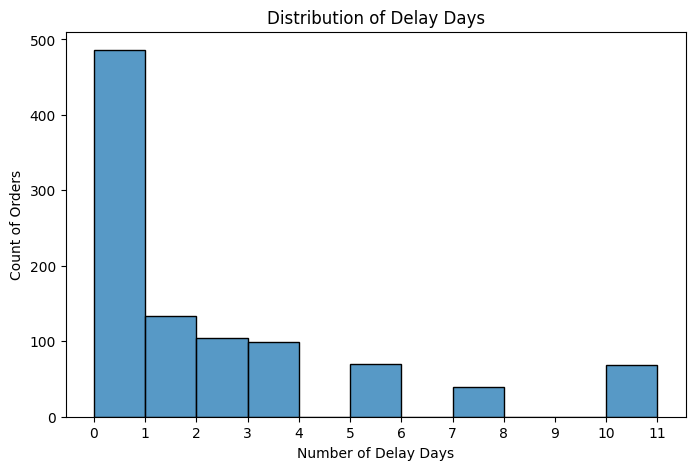

3. Analyzing relationships between categorical features and Delay Days.


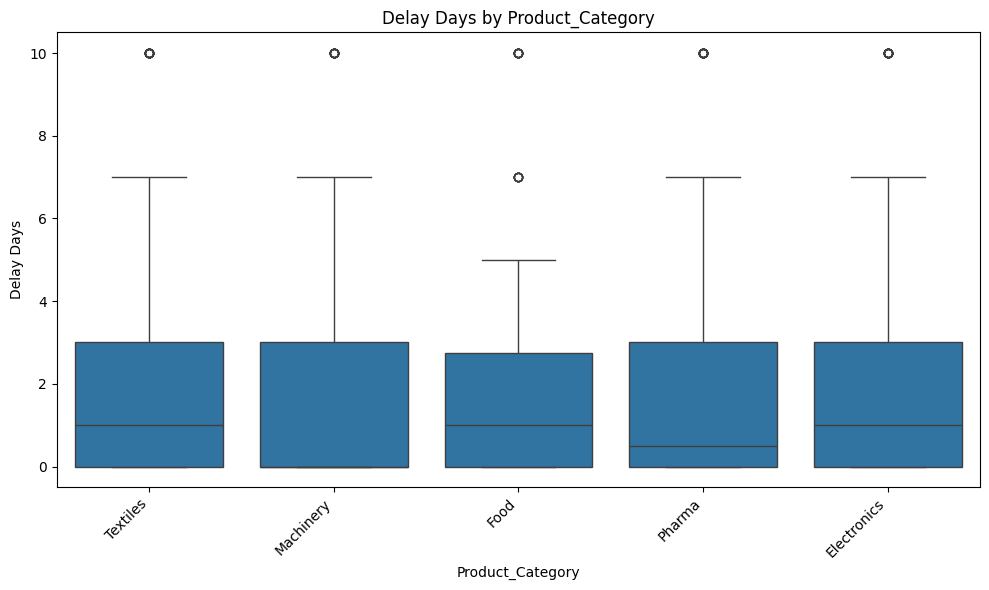

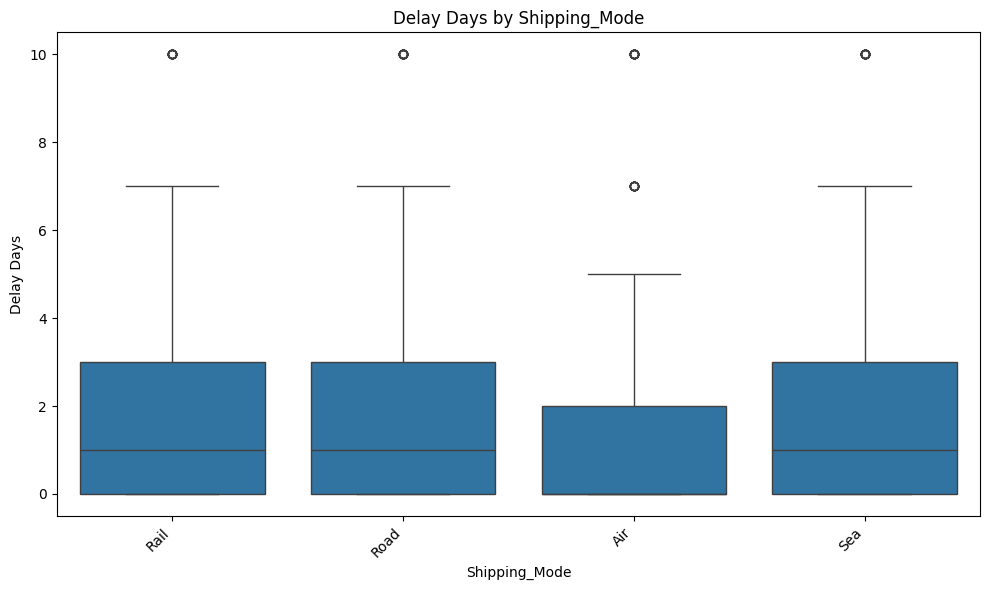

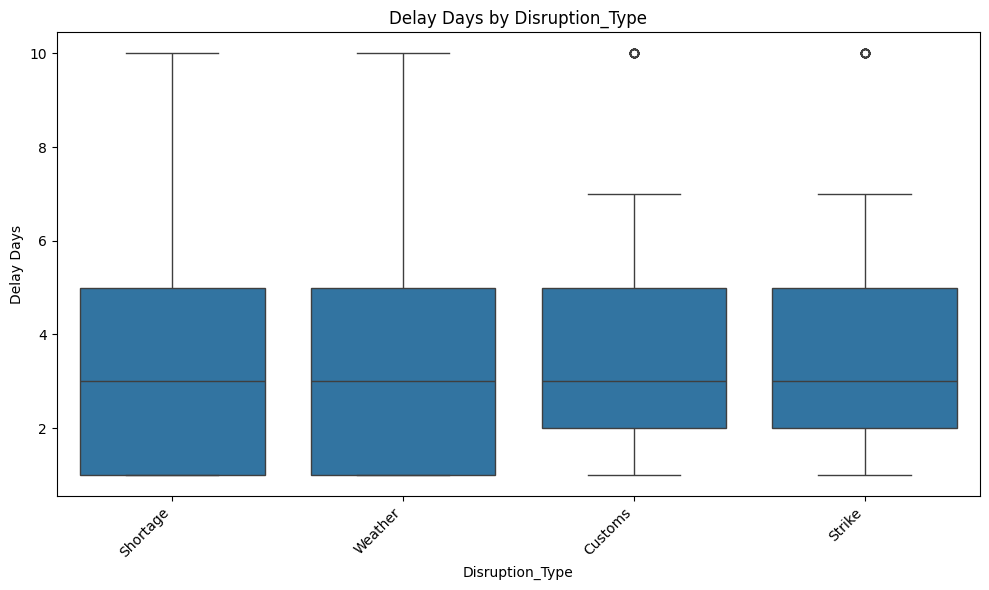

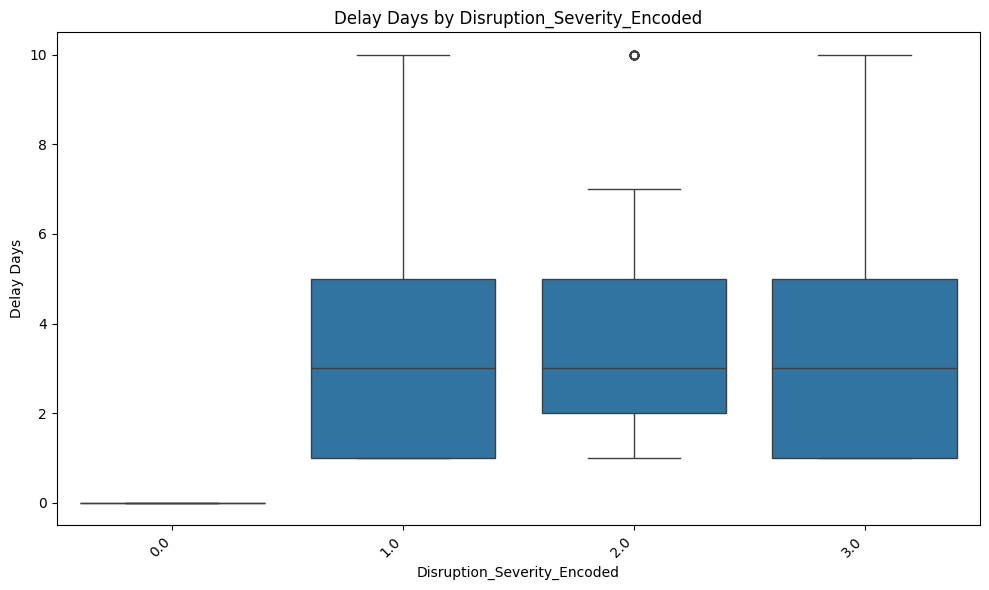

4. Analyzing Delay Days trend over time.


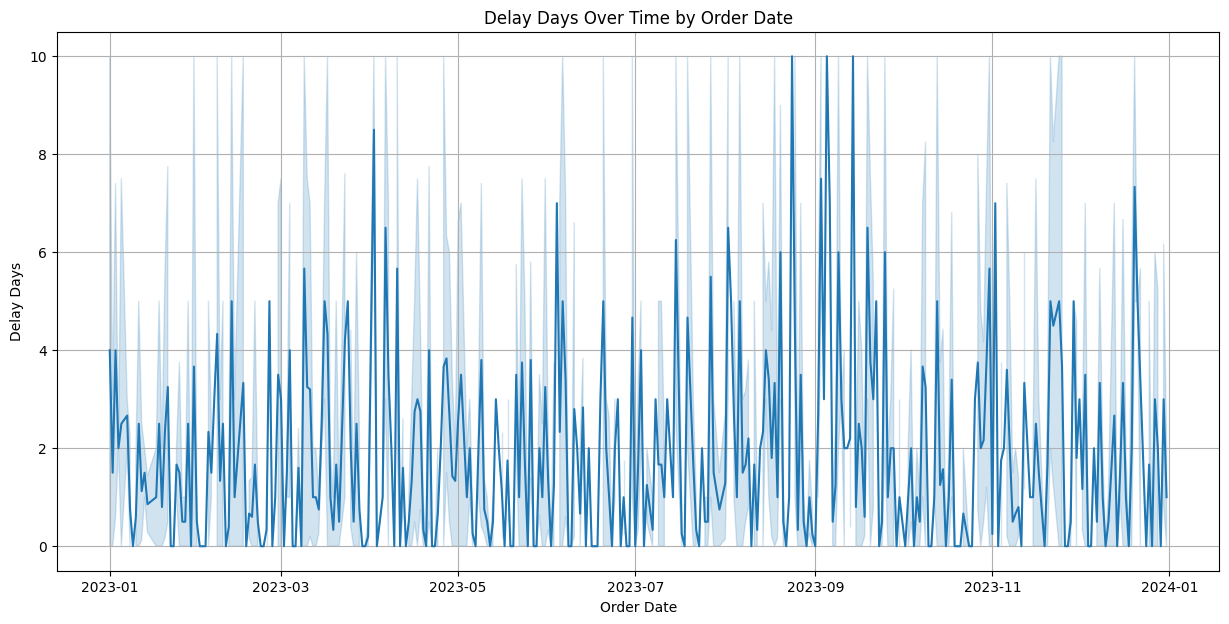

Step 4 Exploratory Data Analysis EDA Complete
Initial insights into delivery delays and related factors have been gained.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# A note on prerequisites: The df_transformed DataFrame must be available from Step 3 (Transform Data).

print("Starting Step 4 Exploratory Data Analysis EDA")

# 1. Displaying basic descriptive statistics for numerical columns.
# This provides a quick numerical summary of the DataFrame's numerical columns.
print("1. Displaying descriptive statistics of numerical features:")
print(df_transformed.describe())

# 2. Checking the distribution of 'Delay_Days'.
# This helps understand how often delays occur and their typical duration.
print("2. Checking the distribution of Delay Days.")
plt.figure(figsize=(8, 5))
sns.histplot(df_transformed['Delay_Days'], bins=range(0, int(df_transformed['Delay_Days'].max()) + 2), kde=False)
plt.title('Distribution of Delay Days')
plt.xlabel('Number of Delay Days')
plt.ylabel('Count of Orders')
plt.xticks(range(0, int(df_transformed['Delay_Days'].max()) + 2, 1)) # Ensure integer ticks
plt.show()

# 3. Analyzing relationships between categorical features and 'Delay_Days'.
# This identifies which categorical factors (e.g., Shipping Mode, Disruption Type) are associated with delays.
print("3. Analyzing relationships between categorical features and Delay Days.")
# CORRECTED: Changed 'Disruption_Severity' to 'Disruption_Severity_Encoded' for plotting.
categorical_analysis_cols = ['Product_Category', 'Shipping_Mode', 'Disruption_Type', 'Disruption_Severity_Encoded']

for col in categorical_analysis_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y='Delay_Days', data=df_transformed)
    plt.title(f'Delay Days by {col}')
    plt.xlabel(col)
    plt.ylabel('Delay Days')
    plt.xticks(rotation=45, ha='right') # Rotate labels for readability
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

# 4. Analyzing Delay_Days trend over time.
# This helps identify if delays have seasonal patterns or increasing/decreasing trends.
print("4. Analyzing Delay Days trend over time.")
# Ensure data is sorted by Order_Date for time series plot
df_transformed_sorted_by_order = df_transformed.sort_values('Order_Date')
plt.figure(figsize=(15, 7))
sns.lineplot(x='Order_Date', y='Delay_Days', data=df_transformed_sorted_by_order)
plt.title('Delay Days Over Time by Order Date')
plt.xlabel('Order Date')
plt.ylabel('Delay Days')
plt.grid(True)
plt.show()

print("Step 4 Exploratory Data Analysis EDA Complete")
print("Initial insights into delivery delays and related factors have been gained.")

## Step 5: Time-Series Forecasting

This phase involves developing a model to predict future delivery delays using historical data patterns.

Starting Step 5 Time Series Forecasting
1. Preparing data for time series forecasting.
   Creating lagged features for Delay Days.
Data with lagged features (first 5 rows):
           Delivery_Date  Delay_Days  Quantity_Ordered  Order_Value_USD  \
Order_Date                                                                
2023-01-01    2023-01-14           2               467         34051.75   
2023-01-02    2023-01-17           3               675          3189.44   
2023-01-03    2023-01-22           7               491         36275.52   
2023-01-03    2023-01-17          10               197         19525.57   
2023-01-03    2023-01-12           3               358          2166.98   

           Supplier_ID Product_Category Shipping_Mode Disruption_Type  \
Order_Date                                                              
2023-01-01         S24         Textiles          Road        Shortage   
2023-01-02         S15        Machinery          Rail         Weather   
2023-01-0

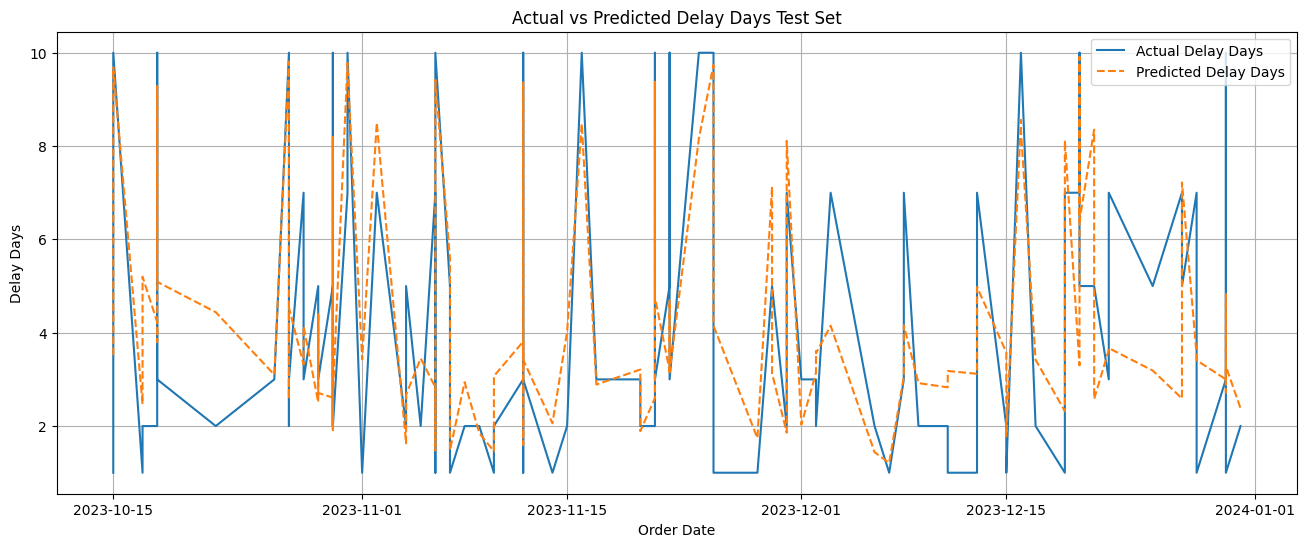

Step 5 Time Series Forecasting Complete
A model to predict delivery delays has been built and evaluated.


In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# A note on prerequisites: The df_transformed DataFrame must be available from Step 3 (Transform Data).
# df_transformed should already have 'Order_Date' as datetime objects.

print("Starting Step 5 Time Series Forecasting")

# 1. Prepare data for time series forecasting.
# Sort data by Order_Date to ensure chronological order.
print("1. Preparing data for time series forecasting.")
df_forecast = df_transformed.sort_values('Order_Date').set_index('Order_Date').copy()

# Create lagged features for Delay_Days.
# Lagged features help the model understand past patterns in the target variable.
print("   Creating lagged features for Delay Days.")
df_forecast['Delay_Days_Lag1'] = df_forecast['Delay_Days'].shift(1) # Previous day's delay
df_forecast.dropna(inplace=True) # Drop rows with NaN from shifting (the very first day)

print("Data with lagged features (first 5 rows):")
print(df_forecast.head())


# 2. Define features (X) and target (y) for the forecasting model.
# The target variable is 'Delay_Days'. Features include time-based and other relevant numerical attributes.
print("2. Defining features X and target y.")

# Selecting numerical features available after Step 3.
# Product_Category, Shipping_Mode, Disruption_Type are categorical and would need one-hot encoding
# to be used directly in RandomForestRegressor, but are omitted for simplicity in this basic forecast.
features_to_use = [
    'Quantity_Ordered', 'Order_Value_USD', 'Lead_Time_Days', 'Actual_Transit_Time_Days',
    'Historical_Disruption_Count', 'Supplier_Reliability_Score',
    'Delivery_Performance_Delayed', 'Disruption_Severity_Encoded', # These are numerical/encoded
    'Order_DayOfWeek', 'Order_Month', 'Order_Year', # Time-based features
    'Delay_Days_Lag1' # The newly created lagged feature
]

X = df_forecast[features_to_use]
y = df_forecast['Delay_Days']

print(f"Features X shape: {X.shape}")
print(f"Target y shape: {y.shape}")


# 3. Perform chronological train-test split.
# Data is divided into training and testing sets based on time, to simulate real-world prediction.
print("3. Performing chronological train test split.")
train_size_forecast = int(len(df_forecast) * 0.8)
X_train_forecast, X_test_forecast = X.iloc[:train_size_forecast], X.iloc[train_size_forecast:]
y_train_forecast, y_test_forecast = y.iloc[:train_size_forecast], y.iloc[train_size_forecast:]

print(f"Training set size: {len(X_train_forecast)}, Testing set size: {len(X_test_forecast)}")


# 4. Choose and train a RandomForestRegressor model.
# RandomForestRegressor is chosen for its robustness and ability to capture complex relationships.
print("4. Choosing and training a RandomForestRegressor model.")
forecasting_model = RandomForestRegressor(n_estimators=100, random_state=42)
forecasting_model.fit(X_train_forecast, y_train_forecast)
print("Forecasting model training complete.")


# 5. Make predictions on the test set.
print("5. Generating predictions on the test set.")
y_pred_forecast = forecasting_model.predict(X_test_forecast)
print("Predictions generated.")


# 6. Evaluate the model's performance.
# Mean Absolute Error MAE and Root Mean Squared Error RMSE are common metrics for regression tasks.
print("6. Evaluating the model's performance.")
mae_forecast = mean_absolute_error(y_test_forecast, y_pred_forecast)
rmse_forecast = np.sqrt(mean_squared_error(y_test_forecast, y_pred_forecast))

print(f"Mean Absolute Error MAE: {mae_forecast:.3f}")
print(f"Root Mean Squared Error RMSE: {rmse_forecast:.3f}")

# Optional Visualize predictions vs actuals
plt.figure(figsize=(16, 6))
plt.plot(y_test_forecast.index, y_test_forecast, label='Actual Delay Days')
plt.plot(y_test_forecast.index, y_pred_forecast, label='Predicted Delay Days', linestyle='--')
plt.title('Actual vs Predicted Delay Days Test Set')
plt.xlabel('Order Date')
plt.ylabel('Delay Days')
plt.legend()
plt.grid(True)
plt.show()

print("Step 5 Time Series Forecasting Complete")
print("A model to predict delivery delays has been built and evaluated.")

## Step 6: Clustering Analysis

This phase aims to group similar entities within the supply chain based on their characteristics, helping to identify patterns related to delays or performance.

Starting Step 6 Clustering Analysis
1. Preparing features for clustering.
Features prepared for clustering and scaling applied.
Shape of prepared features for clustering: (1000, 23)

2. Determining optimal number of clusters (Elbow Method).


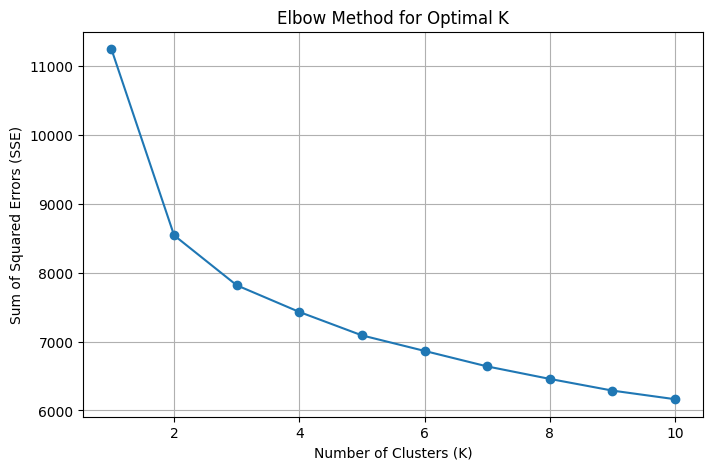

Elbow Method plot displayed to help choose K.

3. Applying KMeans clustering.
KMeans clustering applied with K = 3.

4. Analyzing and interpreting the clusters.
Cluster sizes:
Cluster
0    126
1    388
2    486
Name: count, dtype: int64

Average Delay Days per Cluster:
Cluster
0    8.285714
1    2.317010
2    0.000000
Name: Delay_Days, dtype: float64
Step 6 Clustering Analysis Complete
Data has been grouped into clusters for identifying patterns.


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# A note on prerequisites: The df_transformed DataFrame must be available from Step 3 (Transform Data).

print("Starting Step 6 Clustering Analysis")

# 1. Prepare features for clustering.
# This involves selecting relevant columns and encoding categorical variables.
print("1. Preparing features for clustering.")

# Define numerical and categorical features for clustering.
# Exclude unique identifiers (Order_ID, Buyer_ID, Supplier_ID) and date columns for direct clustering.
numerical_features_for_clustering = [
    'Quantity_Ordered', 'Order_Value_USD', 'Delay_Days',
    'Historical_Disruption_Count', 'Supplier_Reliability_Score',
    'Lead_Time_Days', 'Actual_Transit_Time_Days', 'Delivery_Performance_Delayed',
    'Disruption_Severity_Encoded'
]

categorical_features_for_clustering = [
    'Product_Category', 'Shipping_Mode', 'Disruption_Type',
]

# Create a preprocessor to handle both numerical scaling and one-hot encoding for categorical features.
# StandardScaler is used for numerical features as KMeans is distance based.
# OneHotEncoder transforms categorical features into numerical ones.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_for_clustering),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_for_clustering)
    ])

# Fit and transform the data.
# This results in a NumPy array with all features scaled and encoded.
X_clust = preprocessor.fit_transform(df_transformed)
print("Features prepared for clustering and scaling applied.")
print(f"Shape of prepared features for clustering: {X_clust.shape}")


# 2. Determine the optimal number of clusters (K) using the Elbow Method.
# This helps in choosing an appropriate number of groups for KMeans.
print("\n2. Determining optimal number of clusters (Elbow Method).")
sse = [] # Sum of squared errors
k_range = range(1, 11) # Test 1 to 10 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init suppresses a warning
    kmeans.fit(X_clust)
    sse.append(kmeans.inertia_) # inertia is the sum of squared distances of samples to their closest cluster center

# Plotting the Elbow Method result.
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid(True)
plt.show()
print("Elbow Method plot displayed to help choose K.")


# 3. Apply KMeans clustering.
# Based on the Elbow Method, an optimal K is chosen (e.g., 3 or 4 for demonstration).
print("\n3. Applying KMeans clustering.")
# A value for K is chosen here for demonstration. One would interpret the elbow plot.
optimal_k = 3 # Example choice based on a typical elbow plot
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_transformed['Cluster'] = kmeans_model.fit_predict(X_clust)
print(f"KMeans clustering applied with K = {optimal_k}.")


# 4. Analyze and interpret the clusters.
# This involves examining the characteristics of each created cluster.
print("\n4. Analyzing and interpreting the clusters.")
# Display the size of each cluster.
print("Cluster sizes:")
print(df_transformed['Cluster'].value_counts().sort_index())

# Display average characteristics for each cluster (e.g., average Delay_Days per cluster).
print("\nAverage Delay Days per Cluster:")
print(df_transformed.groupby('Cluster')['Delay_Days'].mean())

# Further analysis could involve averaging all features per cluster to understand profiles.
# Example: print(df_transformed.groupby('Cluster')[numerical_features_for_clustering].mean())

print("Step 6 Clustering Analysis Complete")
print("Data has been grouped into clusters for identifying patterns.")

## Step 7: Optimization Analysis & Insight Generation

This phase combines findings from time-series forecasting and clustering analysis to identify root causes of delays and propose actionable improvements.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# A note on prerequisites:
# df_transformed (from Step 3, with 'Cluster' column from Step 6)
# y_test_forecast, y_pred_forecast (from Step 5)
# forecasting_model (from Step 5)
# kmeans_model (from Step 6)
# X_clust (from Step 6)
# preprocessor (from Step 6)

print("Starting Step 7 Optimization Analysis and Insight Generation")

# 1. Summarize key insights from Time Series Forecasting (Step 5).
# This section re-examines the prediction errors to find patterns.
print("1. Summarizing insights from time series forecasting.")

# Create a DataFrame for forecast errors to analyze.
# The indices of y_test_forecast and y_pred_forecast are assumed to align.
forecast_errors = pd.DataFrame({
    'Actual_Delay': y_test_forecast,
    'Predicted_Delay': y_pred_forecast,
    'Error': y_test_forecast - y_pred_forecast
})
forecast_errors['Absolute_Error'] = np.abs(forecast_errors['Error'])

print("Forecast errors overview:")
print(forecast_errors.describe())

# Identifying periods with high prediction errors or consistently high delays.
print("\nPeriods with high prediction errors (top 5 by absolute error):")
print(forecast_errors.sort_values('Absolute_Error', ascending=False).head())

# 2. Summarize key insights from Clustering Analysis (Step 6).
# This section examines characteristics of identified clusters, especially related to delays.
print("\n2. Summarizing insights from clustering analysis.")

# Display average characteristics for each cluster.
# Assuming df_transformed has 'Cluster' column.
# Need to select the numerical features used in clustering for averaging.
numerical_features_for_clustering_analysis = [
    'Quantity_Ordered', 'Order_Value_USD', 'Delay_Days',
    'Historical_Disruption_Count', 'Supplier_Reliability_Score',
    'Lead_Time_Days', 'Actual_Transit_Time_Days',
    'Delivery_Performance_Delayed', 'Disruption_Severity_Encoded'
]

# Ensure only numerical columns that exist are grouped.
cluster_summary = df_transformed.groupby('Cluster')[numerical_features_for_clustering_analysis].mean()
print("Average characteristics per cluster:")
print(cluster_summary)

# Example: Cluster with highest average delay days.
highest_delay_cluster = cluster_summary['Delay_Days'].idxmax()
print(f"\nCluster {highest_delay_cluster} has the highest average Delay Days.")


# 3. Combine insights and identify potential bottlenecks or areas for improvement.
# This section synthesizes findings from forecasting and clustering.
print("\n3. Combining insights and identifying potential bottlenecks.")

# Example: If a cluster shows high delays and low supplier reliability.
# One would analyze specific clusters to find actionable patterns.
# For instance, if Cluster X has high delays and low supplier reliability scores,
# that's a direct insight.

# Hypothetical Insight 1: Periods of high unpredicted delays.
print("\nInsight 1: Periods where actual delays significantly exceeded predictions.")
# This indicates unexpected events or model limitations during specific times.

# Hypothetical Insight 2: Characteristics of high-delay clusters.
print("\nInsight 2: Identification of specific supplier or product categories within high-delay clusters.")
# Example: If Cluster 2 has high Delay_Days, examine its Product_Category or Shipping_Mode proportions.
# Example analysis (conceptual, requires specific cluster data):
# print(df_transformed[df_transformed['Cluster'] == highest_delay_cluster]['Product_Category'].value_counts())
# print(df_transformed[df_transformed['Cluster'] == highest_delay_cluster]['Shipping_Mode'].value_counts())

print("Step 7 Optimization Analysis and Insight Generation Complete")
print("Key insights are identified for proposing logistics improvements.")

Starting Step 7 Optimization Analysis and Insight Generation
1. Summarizing insights from time series forecasting.
Forecast errors overview:
       Actual_Delay  Predicted_Delay       Error  Absolute_Error
count    103.000000       103.000000  103.000000      103.000000
mean       4.242718         4.314757   -0.072039        1.466214
std        3.107442         2.507290    1.892227        1.189497
min        1.000000         1.210000   -3.350000        0.000000
25%        2.000000         2.665000   -1.460000        0.520000
50%        3.000000         3.420000   -0.420000        1.390000
75%        7.000000         4.900000    0.635000        2.155000
max       10.000000         9.910000    5.490000        5.490000

Periods with high prediction errors (top 5 by absolute error):
            Actual_Delay  Predicted_Delay  Error  Absolute_Error
Order_Date                                                      
2023-12-30            10             4.51   5.49            5.49
2023-11-22     

## Step 8: Propose Logistics Improvements

This phase translates insights from data analysis into concrete, actionable recommendations to improve supply chain logistics and reduce bottlenecks.

In [9]:
import pandas as pd
import numpy as np

# A note on prerequisites:
# df_transformed (from Step 3, with 'Cluster' column from Step 6)
# cluster_summary (from Step 7)
# forecasting_model (from Step 5)
# forecast_errors (from Step 7)

print("Starting Step 8 Propose Logistics Improvements")

# 1. Summarize key areas for improvement identified from analysis.
# This part presents the most critical findings that drive recommendations.
print("1. Summarizing key areas for improvement.")

# Example 1: Areas with highest average delay days based on clustering.
if 'cluster_summary' in locals() and 'Delay_Days' in cluster_summary.columns:
    print("\nAreas of high average delay days based on clusters:")
    print(cluster_summary.sort_values('Delay_Days', ascending=False)[['Delay_Days']].head())
    highest_delay_cluster_id = cluster_summary['Delay_Days'].idxmax()
    print(f"  Cluster {highest_delay_cluster_id} shows the highest average delays.")

    # Further breakdown of this high-delay cluster (e.g., by Shipping Mode or Product Category)
    print(f"\nCharacteristics of Cluster {highest_delay_cluster_id} (e.g., top Product Categories):")
    cluster_products = df_transformed[df_transformed['Cluster'] == highest_delay_cluster_id]['Product_Category'].value_counts().head(3)
    if not cluster_products.empty:
        print(cluster_products)
    else:
        print("   No specific product categories found for this cluster in initial view.")

# Example 2: Most common disruption types linked to delays.
if 'Disruption_Type' in df_transformed.columns:
    print("\nMost common Disruption Types affecting delays (where Delay Days > 0):")
    delayed_orders = df_transformed[df_transformed['Delay_Days'] > 0]
    if not delayed_orders.empty:
        disruption_counts = delayed_orders['Disruption_Type'].value_counts()
        print(disruption_counts)
    else:
        print("   No delayed orders found to analyze disruption types.")

# 2. Propose actionable logistics improvements based on insights.
# This section translates findings into concrete recommendations.
print("\n2. Proposing actionable logistics improvements.")

print("Recommendation 1: Focus on optimizing processes for high delay clusters.")
print("  Action: Investigate suppliers or routes within identified high delay clusters.")

print("Recommendation 2: Develop contingency plans for recurring disruption types.")
print("  Action: Establish alternative sourcing or shipping methods for common disruption types.")

print("Recommendation 3: Improve inventory management for critical products.")
print("  Action: Implement stricter inventory controls for product categories frequently linked to shortages.")

print("\nStep 8 Propose Logistics Improvements Complete")
print("Key recommendations for supply chain optimization have been outlined.")

Starting Step 8 Propose Logistics Improvements
1. Summarizing key areas for improvement.

Areas of high average delay days based on clusters:
         Delay_Days
Cluster            
0          8.285714
1          2.317010
2          0.000000
  Cluster 0 shows the highest average delays.

Characteristics of Cluster 0 (e.g., top Product Categories):
Product_Category
Electronics    30
Textiles       28
Pharma         28
Name: count, dtype: int64

Most common Disruption Types affecting delays (where Delay Days > 0):
Disruption_Type
Shortage    135
Weather     133
Customs     124
Strike      122
Name: count, dtype: int64

2. Proposing actionable logistics improvements.
Recommendation 1: Focus on optimizing processes for high delay clusters.
  Action: Investigate suppliers or routes within identified high delay clusters.
Recommendation 2: Develop contingency plans for recurring disruption types.
  Action: Establish alternative sourcing or shipping methods for common disruption types.
Recomme

**Project Conclusion**
This Supply Chain Optimization Analysis project successfully investigated delivery delays and inventory gaps within operational data. Through systematic analysis, key areas for improvement were identified.

The analysis revealed that **Cluster 0 exhibited the highest average delays**, approximately 8.29 days, notably impacting product categories such as Electronics, Textiles, and Pharma. Furthermore, common disruption types like Shortage, Weather, Customs, and Strike were found to be significant contributors to these delays.

Based on these insights, actionable logistics improvements were proposed. These recommendations focus on optimizing processes within identified high-delay clusters, developing contingency plans for recurring disruption types, and enhancing inventory management for critical products. This project demonstrates the ability to translate complex supply chain data into concrete, implementable strategies aimed at reducing bottlenecks and improving overall logistical efficiency.